In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import tensorflow as tf

from tensorflow.python.client import device_lib
from tensorflow import keras
from torchvision import models

from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras import backend as K
from keras.callbacks import EarlyStopping as ES
from keras.callbacks import ModelCheckpoint
from keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

from matplotlib.patches import Rectangle 
from matplotlib.pyplot import matshow

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# The German Traffic Sign Recognition Benchmark
#
# sample code for reading the traffic sign images and the
# corresponding labels
#
# example:
#            
# trainImages, trainLabels = readTrafficSigns('GTSRB/Training')
# print len(trainLabels), len(trainImages)
# plt.imshow(trainImages[42])
# plt.show()
#
# have fun, Christian

# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSignsFinalTest(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    boundary = []
    labels = [] # corresponding labels
    # loop over all 42 classes
    #for c in range(0,43):
    prefix = rootpath + '/' # add /
    gtFile = open('C:/Users/frank/Documents/AI Project/GTSRB/Final_Test/Images/GT-final_test.test.csv') # annotations file
    gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
    next(gtReader) # skip header
    # loop over all images in current annotations file
    for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1st column is the filename
            labels.append(row[7]) # the 8th column is the label
            boundary.append(row[3:7])
    gtFile.close()
    return images, boundary, labels

In [3]:
# Load data
train_Examples, train_boundary, train_labels = readTrafficSignsFinalTest('C:/Users/frank/Documents/AI Project/GTSRB/Final_Test/Images')

train_Examples = np.asarray(train_Examples)
train_boundary = np.asarray(train_boundary)
train_labels = np.asarray(train_labels)

In [4]:
#Process the data, we are only interested in images that are lass than 101 pixels wide and tall
count = 0
for i in range(len(train_Examples)):
    rows, columns, rgb = train_Examples[i].shape
    if rows < 101 and columns < 101:
        count+=1

data = np.zeros((count,100,100,3), dtype=int)

iterator = 0

for i in range(len(train_Examples)):
    
    rows,columns,rgb = train_Examples[i].shape
    
    value = train_Examples[i]
    
    if rows < 101 and columns < 101:
    
        for j in range(rows):
        
            for n in range(columns):
            
                for k in range(rgb):
                    data[iterator,j,n,k] = value[j,n,k]
                    #print(value[j,n,k])
        iterator += 1
        
labels = np.zeros((count,1))
boundary = np.zeros((count,4))

iterator = 0

for i in range(len(train_Examples)):
    x = train_Examples[i]
    row,column,rgb = x.shape
    
    if row < 101 and column < 101:
        labels[iterator,0] = train_labels[i]
        boundary[iterator, 0] = int(train_boundary[i,0])/100 #divide by 100 to put it in range of the sigmoid function
        boundary[iterator, 1] = int(train_boundary[i,1])/100
        boundary[iterator, 2] = int(train_boundary[i,2])/100
        boundary[iterator, 3] = int(train_boundary[i,3])/100
        iterator += 1
        
n_classes = 43

denseTestData = data.reshape(count, 100*100*3).astype('float32')

categoricalLabels = keras.utils.to_categorical(labels, n_classes)

In [18]:
#Load models
DenseBB = keras.models.load_model('C:/Users/frank/Documents/AI Project/DenseModelBB.h5')
DenseClassifier = keras.models.load_model('C:/Users/frank/Documents/AI Project/DenseModel.h5')
convBB = keras.models.load_model('C:/Users/frank/Documents/AI Project/convBB.h5')
convClassifier = keras.models.load_model('C:/Users/frank/Documents/AI Project/convModel.h5')

DenseBB.trainable = False
DenseClassifier.trainable = False
convBB.trainable = False
convClassifier.trainable = False

In [6]:
#Evaluate Dense Model Bounding Box
DenseBB.evaluate(denseTestData, boundary)

374/374 [==============================] - 1s 3ms/step - loss: 4.9263e-04 - mean_squared_error: 4.9263e-04


[0.0004926330293528736, 0.0004926330293528736]

In [16]:
convBB.evaluate(data,boundary)

374/374 [==============================] - 17s 46ms/step - loss: 0.9867 - accuracy: 0.8940


[0.986700177192688, 0.8940231204032898]

In [14]:
def BoundingBoxAccuracy(pred, grTruth):
    if len(pred) != len(grTruth):
        return "Arrays must be the same length!"
    
    total = 0
    length = len(pred)
    wrong = 0
    correct = 0
    total = len(pred)
    wrong_array = []
    
    for i in range(length):
        pred[i] = pred[i] * 100
        grTruth[i] = grTruth[i] * 100
    
    
    for i in range(length):
        absoluteDifference = abs(grTruth[i][0] - pred[i][0]) + abs(grTruth[i][1] - pred[i][1]) + abs(grTruth[i][2] - pred[i][2]) + abs(grTruth[i][3] - pred[i][3])
        maxSingleDif = max(abs(grTruth[i][0] - pred[i][0]), abs(grTruth[i][1] - pred[i][1]), abs(grTruth[i][2] - pred[i][2]), abs(grTruth[i][3] - pred[i][3]))
        
        if absoluteDifference > 32 or maxSingleDif > 10:
            wrong += 1
            wrong_array.append(i)
        else:
            correct += 1
    
    accuracy = (correct/total) * 100
    
    for i in range(length):
        grTruth[i] = grTruth[i] / 100
    
    print('Total wrong: ', wrong)
    print('Total correct: ', correct)
    print('Accuracy: ', accuracy, '%')
    
    #return wrong_array
    

In [15]:
#Evaluate the Bounding Box predictions
DenseBBPrediction = DenseBB.predict(denseTestData)
CNNBBPrediction = convBB.predict(data)

print("Dense Model Bounding Box Results: ")
denseModelBBResults = BoundingBoxAccuracy(DenseBBPrediction, boundary)

print("CNN Model Bounding Box Results: ")
CNNModelBBResults = BoundingBoxAccuracy(CNNBBPrediction, boundary)

Dense Model Bounding Box Results: 
Total wrong:  170
Total correct:  11776
Accuracy:  98.57692951615603 %
CNN Model Bounding Box Results: 
Total wrong:  11878
Total correct:  68
Accuracy:  0.5692281935375858 %


374/374 [==============================] - 1s 3ms/step - loss: 2.5545 - accuracy: 0.6351


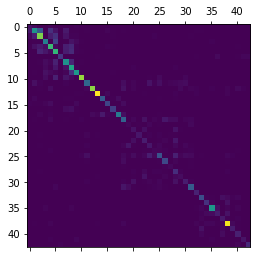

In [19]:
#Evaluate Dense Model Classifier
DenseClassifier.evaluate(denseTestData, categoricalLabels)
densePredicted = DenseClassifier.predict(denseTestData)
densePredicted = np.argmax(densePredicted, axis=1)
densePredicted = densePredicted.tolist()
matrix = confusion_matrix(labels,densePredicted)
matshow(matrix)

374/374 [==============================] - 17s 46ms/step - loss: 0.2945 - accuracy: 0.9295


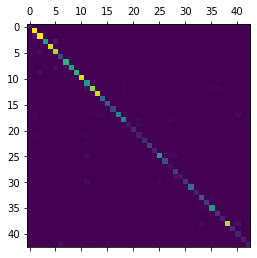

In [9]:
#Evaluate CNN Model Classifier
convClassifier.evaluate(data, categoricalLabels)
CNNPredicted = convClassifier.predict(data)
CNNPredicted = np.argmax(CNNPredicted, axis=1)
CNNPredicted = CNNPredicted.tolist()
matrix = confusion_matrix(labels,CNNPredicted)
matshow(matrix)

In [10]:
print(classification_report(densePredicted, labels))
print(classification_report(CNNPredicted, labels))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.32      0.65      0.43       341
         2.0       0.44      0.42      0.43       746
         3.0       0.50      0.40      0.44       550
         4.0       0.65      0.44      0.52       964
         5.0       0.15      0.34      0.21       283
         6.0       0.62      0.79      0.70       117
         7.0       0.27      0.74      0.39       160
         8.0       0.45      0.37      0.41       538
         9.0       0.61      0.56      0.58       511
        10.0       0.75      0.78      0.76       617
        11.0       0.43      0.65      0.52       248
        12.0       0.84      0.84      0.84       631
        13.0       0.92      0.73      0.82       794
        14.0       0.56      0.77      0.65       165
        15.0       0.54      0.38      0.44       284
        16.0       0.37      0.92      0.53        61
        17.0       0.80    

C:\Users\frank\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
def BoundingBoxPrediction(values, n):
    
    shapedValues = values.reshape(len(values), 100*100*3).astype('float32')
    

    BB = DenseBB.predict(shapedValues)
    #BB = convBB.predict(values)
    
    x1,y1,x2,y2=BB[n-1][0], BB[n-1][1], BB[n-1][2], BB[n-1][3],
    
    print(x1,y1,x2,y2)
    
    fig,ax = plt.subplots(1)

    img = data[n-1][:][:][:][:]
    
    ax.imshow(img)

    rect = Rectangle((x1*100,y1*100),(x2*100)-(x1*100),(y2*100)-(y1*100),linewidth=1,edgecolor='r',facecolor='none')
    
    ax.add_patch(rect)

    #plt.savefig('C:/Users/frank/Documents/AI Project/Figures/3500Correct.png')
    
    plt.show

0.054273635 0.05426708 0.35474873 0.35456997


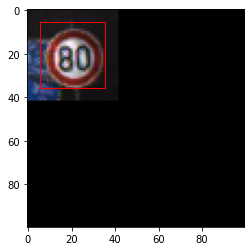

In [26]:
BoundingBoxPrediction(data,350)

0.05361095 0.053600222 0.3411455 0.34320366


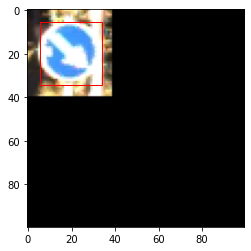

In [24]:
BoundingBoxPrediction(data,10000)

0.05554554 0.05504158 0.4481545 0.4395896


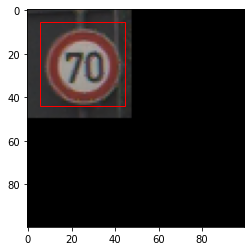

In [25]:
BoundingBoxPrediction(data,8000)